# SimPEG(emg3d) -- small dev-example

Use either via

- `conda env create -f environment-simpeg-emg3d.yml`

(creates env `simpeg-emg3d`), or manually by installing

- SimPEG: `pip install git+https://github.com/prisae/simpeg@generalization-for-emg3d`
- emg3d: `pip install git+https://github.com/emsig/emg3d@simpeg`
- Additionally: `xarray`, `matplotlib`, `ipympl`

## TODOs:
- Clean-up the two PR's
- Change this example to create survey and simulation with emg3d, and use simpeg only for the inversion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import simpeg
import simpeg.electromagnetics.frequency_domain as FDEM

In [2]:
%matplotlib widget

## Create a grid

Very small now, for dev purposes.

In [3]:
frequency = 2.
seafloor = -2000.
#min_cell = 100.  # => 81,920 cells, 5 sources, 41 receivers
min_cell = 200.  # => 18,432 cells, 3 sources, 21 receivers

mesh = emg3d.construct_mesh(
    center=(min_cell/2, 0, seafloor),  # Smallest cell at center
    frequency=1.,          # Reference frequency
    properties=(0.3, 1, 1, 0.3),  # Reference resistivity
    min_width_limits=min_cell,
    # Domain in which we want precise results
    domain=([-2000, 2000],    # x-dir: where we have receivers
            [-1000, 1000],    # y-dir: just extent of target
            [seafloor-1000, seafloor+500]),  # 
    mapping='Conductivity',
    center_on_edge=True,
)

# Active cells for inversion: everything below water
inds_active = mesh.cell_centers[:, 2] < seafloor

mesh

TensorMesh: 18,432 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     32     -5,197.13      6,729.30    200.00  1,532.17    1.40
   y     24     -4,186.99      4,186.99    200.00    746.72    1.21
   z     24     -6,449.09      4,341.71    200.00  1,263.28    1.23

## Create a model

Deep marine scenario, so we can ignore the air layer for developing.

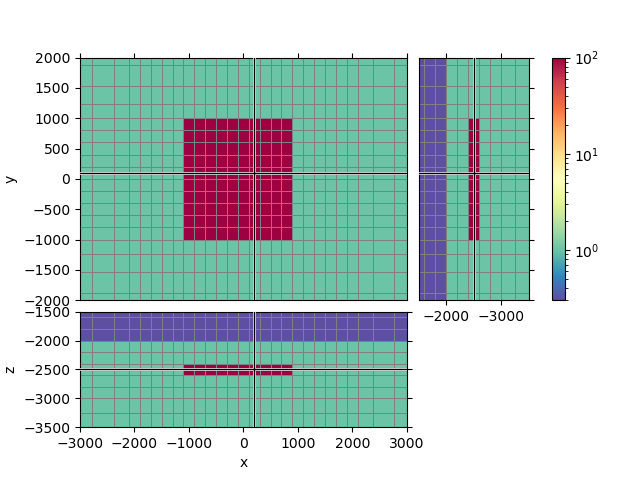

Model: conductivity; isotropic; 32 x 24 x 24 (18,432)

In [4]:
# Initiate with background resistivity
sigma = np.ones(mesh.n_cells)

# Add water layer
sigma[mesh.cell_centers[:, 2] > seafloor] = 1/0.3

# Add target
inds_target = (
    (abs(mesh.cell_centers[:, 0]) < 1000) &
    (abs(mesh.cell_centers[:, 1]) < 1000) &
    np.logical_and(mesh.cell_centers[:, 2] < seafloor-500,
                   mesh.cell_centers[:, 2] > seafloor-700) 
)
sigma[inds_target] = 1/100.

# Create model
model = emg3d.Model(mesh, sigma, mapping='Conductivity')

# QC
mesh.plot_3d_slicer(
    1/sigma,  # Plot resistivities, not conductivities
    pcolor_opts={'edgecolors': 'grey', 'linewidth': 0.5,
                 'cmap':'Spectral_r',
                 'norm':LogNorm(vmin=0.3, vmax=100)}, 
    xlim=[-3000, 3000],
    ylim=[-2000, 2000],
    zlim=[seafloor-1500, seafloor+500],
    zslice=seafloor-500,
)

# QC
model

## Create a survey

For now, we have sources and receivers on the corresponding edges. However, this has to become flexible!

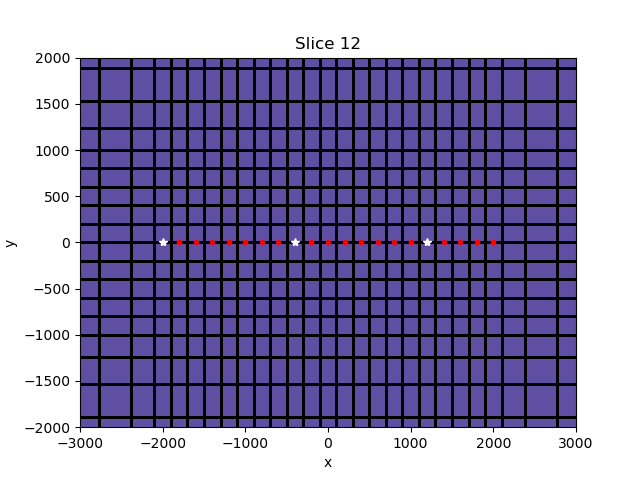

In [5]:
# Receiver line
rec_x = mesh.cell_centers_x[abs(mesh.cell_centers_x) < 2100]
xyz_rx = simpeg.utils.ndgrid(rec_x, 0, seafloor+100)

# Source line
# xyz_src = SimPEG.utils.ndgrid(rec_x[::5], 0, seafloor+100)  # 8 sources
xyz_src = simpeg.utils.ndgrid(rec_x[::8], 0, seafloor+100)  # 5 sources

# QC
mesh.plot_slice(
    1./sigma, grid=True, normal='Z', 
    ind=12,
    pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=1, vmax=100)}, 
    range_x=(-3000, 3000),
    range_y=(-2000, 2000),
)
plt.plot(xyz_rx[:,0], xyz_rx[:,1], 'r.')
plt.plot(xyz_src[:,0], xyz_src[:,1], 'w*')

### For now we only have one receiver list.

**However, we have to test with arbitrary source/receiver/frequency combination, if the interaction SimPEG(emg3d) works.**

In [6]:
rx_list = [
    FDEM.receivers.PointElectricField(
        orientation='x', component="complex", locations=xyz_rx),
]

src_list = []
for ii in range(xyz_src.shape[0]):
    src = FDEM.sources.ElectricDipole(
        rx_list, location=xyz_src[ii,:], frequency=frequency, azimuth=0, elevation=0)
    src_list.append(src)

survey = FDEM.Survey(src_list)

## Create SimPEG-Simulation

In [7]:
active_map = simpeg.maps.InjectActiveCells(mesh, inds_active, sigma[~inds_active])
nP = int(inds_active.sum())
conductivity_map = active_map * simpeg.maps.ExpMap(nP=nP)

In [8]:
# Define the Simulation
simulation = emg3d.inversion.simpeg.FDEMSimulation(
        mesh,
        survey=survey,
        sigmaMap=conductivity_map,
        verbose=False,
#        simulation_opts={
#            'solver_opts': {
#                'maxit': 1,     # To speed up for testing
#                'plain': True   # " "  (fails faster)
#            },
#            'verb': -1,         # To not raise convergence warnings
#        },
)

# True and initial model
m_true =  np.log(sigma[inds_active])
m0 =  np.ones(m_true.shape) * np.log(1.)

## QC emg3d-Survey created by SimPEG

In [9]:
simulation.emg3d_survey

:: Survey «Survey created by SimPEG» ::

<xarray.Dataset> Size: 2kB
Dimensions:   (src: 3, rec: 21, freq: 1)
Coordinates:
  * src       (src) <U6 72B 'TxED-1' 'TxED-2' 'TxED-3'
  * rec       (rec) <U7 588B 'RxEP-01' 'RxEP-02' ... 'RxEP-20' 'RxEP-21'
  * freq      (freq) <U3 12B 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 1kB (nan+nanj) ... (nan+nanj)
    indices   (src, rec, freq) int64 504B 0 1 2 3 4 5 6 ... 56 57 58 59 60 61 62
Attributes:
    noise_floor:     1.0
    relative_error:  None

## => Currently, `f` returns a emg3d-simulation, and `dpred` an ndarray. This should change to SimPEG fields- and data-objects, I think

In [10]:
f = simulation.fields(m_true)
d_true = simulation.dpred(m_true, f=f)

In [11]:
d_0 = simulation.dpred(m0)

In [12]:
relative_error = 0.01
noise_floor = 1e-14
standard_deviation = np.sqrt(abs(relative_error*d_true)**2 + (noise_floor)**2)

In [13]:
residual = (d_true - d_0)/standard_deviation

### Question @Seogi: Why are there less data per source than there are receivers?

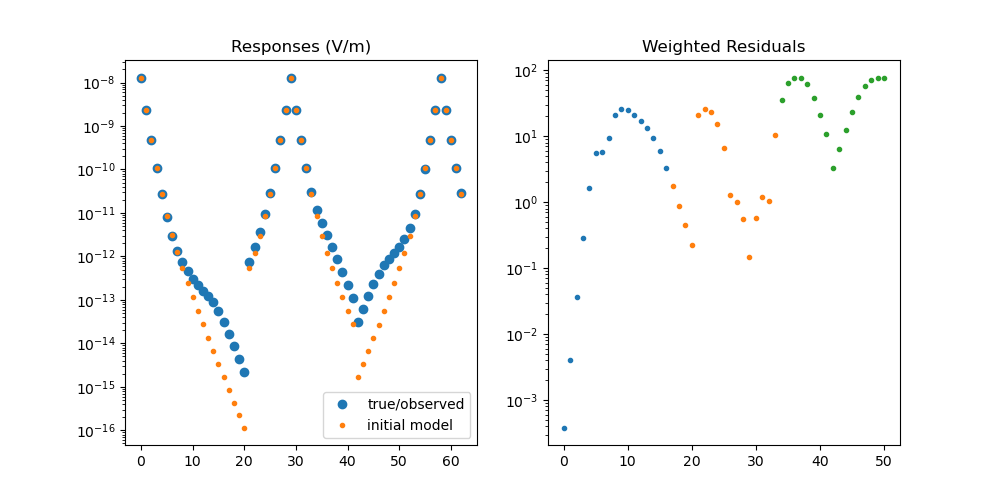

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('Responses (V/m)')
ax1.semilogy(abs(d_true), 'o', label='true/observed')
ax1.semilogy(abs(d_0), '.', label='initial model')
ax1.legend()

ax2.set_title('Weighted Residuals')
nsrc = xyz_src.shape[0]
nrec = len(rec_x)-4
x = np.arange(len(residual))
for s in range(nsrc):
    ax2.semilogy(x[s*nrec:(s+1)*nrec], abs(residual[s*nrec:(s+1)*nrec]), '.')

plt.show()

In [15]:
# NOTE: Once https://github.com/simpeg/simpeg/pull/1523 is in, the `tolist()` can be removed
em_data = simpeg.data.Data(survey, dobs=d_true.tolist(), standard_deviation=standard_deviation)
dmis = simpeg.data_misfit.L2DataMisfit(data=em_data, simulation=simulation)

In [16]:
adjoint_tol = 1e-10
def test_misfit():
    passed = simpeg.tests.check_derivative(
        lambda m: (simulation.dpred(m), lambda mx: simulation.Jvec(m0, mx, f=f)),
        m0,
        plotIt=False,
        num=3,
    )

def test_adjoint():
    # Adjoint Test
    f = simulation.fields(m=m0)
    # u = np.random.rand(.mesh.nC * .survey.nSrc)
    v = np.random.rand(inds_active.sum())
#     v = np.random.rand(mesh.nC)
    w = np.random.rand(simulation.survey.nD)
    wtJv = np.vdot(w, simulation.Jvec(m0, v, f=f)).real
    vtJtw = np.vdot(v, simulation.Jtvec(m0, w, f=f))
    passed = np.abs(wtJv - vtJtw) < adjoint_tol
    print("Adjoint Test", np.abs(wtJv - vtJtw), passed)
    print(wtJv, vtJtw)
    
def test_dataObj():
    passed = simpeg.tests.check_derivative(
        lambda m: [dmis(m), dmis.deriv(m)], m0, plotIt=False, num=2
    )    

In [17]:
test_dataObj()

==================== check_derivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    8.523e+02     7.670e+02      nan
 1   1.00e-02    1.596e+01     7.438e+00      2.013
========================= PASS! =========================
Awesome, Dtr, just awesome.



In [18]:
test_misfit()

==================== check_derivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.204e-10     1.417e-11      nan
 1   1.00e-02    1.230e-11     1.436e-13      1.994
 2   1.00e-03    1.233e-12     1.438e-15      1.999
========================= PASS! =========================
Yay passed!



In [19]:
test_adjoint()

Adjoint Test 1.0854965343682698e-17 True
5.816742546382218e-10 5.816742437832564e-10


In [20]:
%%time

# Define the regularization (model objective function)
reg = simpeg.regularization.WeightedLeastSquares(
    mesh,
    active_cells=inds_active,
    reference_model=m0,
    alpha_s=1e-8,
    alpha_x=1,
    alpha_y=10,
    alpha_z=1
)

nit = 20
#nit = 2
opt = simpeg.optimization.InexactGaussNewton(
    maxIter=nit, maxIterLS=nit, maxIterCG=nit, tolCG=1e-3,
)

inv_prob = simpeg.inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=1)
save = simpeg.directives.SaveOutputDictEveryIteration()

beta_schedule = simpeg.directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target_misfit = simpeg.directives.TargetMisfit(chifact=1)

directives_list = [
    starting_beta,
    beta_schedule,
    target_misfit,
    save
]
em_inversion = simpeg.inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = em_inversion.run(m0)

# NOTE: The ComplexWarnings will disapear once https://github.com/simpeg/simpeg/pull/1524 is in.


Running inversion with SimPEG v0.14.3.dev3195+ge0766b7bb.d20240815

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the FDEMSimulation problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.43e-02  5.57e+04  0.00e+00  5.57e+04    1.55e+04      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


   1  1.22e-02  2.12e+04  1.99e+05  2.37e+04    6.27e+03      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


   2  6.08e-03  1.18e+04  1.48e+05  1.27e+04    1.23e+04      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


   3  3.04e-03  3.51e+03  1.46e+05  3.95e+03    4.13e+03      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


   4  1.52e-03  1.79e+03  1.86e+05  2.08e+03    1.77e+03      0   Skip BFGS  


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


   5  7.60e-04  1.38e+03  2.24e+05  1.55e+03    2.12e+03      1   Skip BFGS  


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


   6  3.80e-04  1.26e+03  3.11e+05  1.38e+03    2.57e+03      0   Skip BFGS  


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


   7  1.90e-04  7.65e+02  3.04e+05  8.22e+02    2.30e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


   8  9.50e-05  6.92e+02  3.65e+05  7.26e+02    3.75e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


   9  4.75e-05  6.01e+02  4.54e+05  6.23e+02    5.08e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  10  2.38e-05  4.91e+02  7.50e+05  5.09e+02    7.22e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  11  1.19e-05  4.18e+02  7.76e+05  4.28e+02    8.82e+01      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  12  5.94e-06  3.95e+02  1.05e+06  4.02e+02    4.37e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  13  2.97e-06  3.66e+02  1.17e+06  3.69e+02    1.42e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  14  1.48e-06  3.48e+02  1.31e+06  3.50e+02    1.40e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  15  7.42e-07  3.32e+02  1.64e+06  3.33e+02    5.00e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  16  3.71e-07  2.96e+02  1.98e+06  2.97e+02    5.44e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  17  1.86e-07  2.66e+02  2.08e+06  2.66e+02    1.97e+02      0   Skip BFGS  


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  18  9.28e-08  2.55e+02  1.99e+06  2.55e+02    1.57e+02      0              


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  19  4.64e-08  2.35e+02  2.13e+06  2.35e+02    3.38e+02      0   Skip BFGS  


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


  20  2.32e-08  2.23e+02  2.07e+06  2.23e+02    7.99e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.1810e+01 <= tolF*(1+|f0|) = 5.5659e+03
0 : |xc-x_last| = 3.3198e+00 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 7.9886e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 7.9886e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =      20    <= iter          =     20
------------------------- DONE! -------------------------
CPU times: user 38 s, sys: 36.3 s, total: 1min 14s
Wall time: 17min 21s


/home/dtr/Codes/simpeg-prisae/simpeg/utils/code_utils.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  printer["format"] % printer["value"](obj)


In [21]:
target_misfit.target

63.0

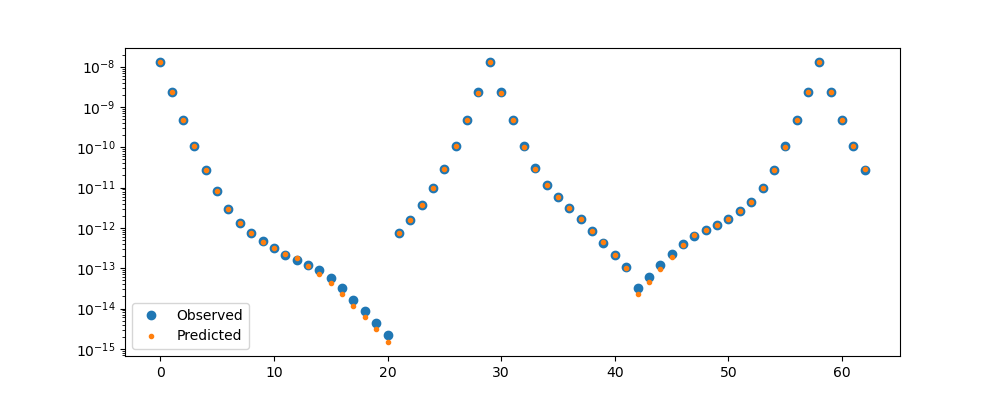

In [22]:
plt.figure(figsize=(10, 4))
iteration = len(save.outDict.keys())
plt.semilogy(abs(em_data.dobs), 'o', label='Observed')
plt.semilogy(abs(save.outDict[iteration]['dpred']), '.', label='Predicted')
plt.legend()

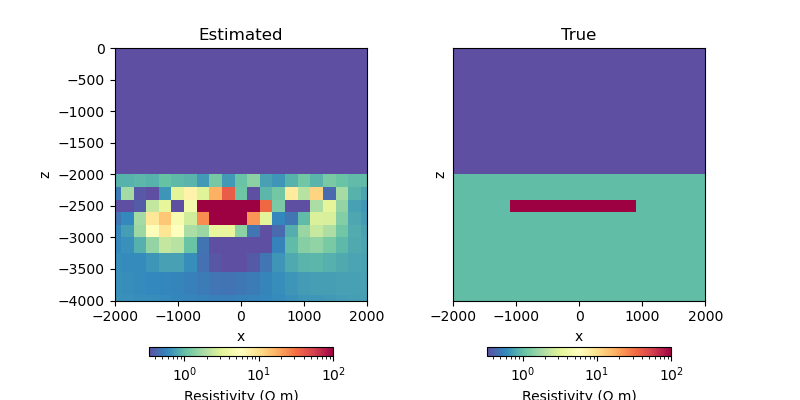

In [23]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

sigm_est = conductivity_map * save.outDict[iteration]['m']
sigmas = [sigm_est, sigma]
titles = ["Estimated", "True"]
for ii, ax in enumerate(axs):
    out = mesh.plot_slice(
        1./sigmas[ii], grid=False, normal='Y', 
        pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=0.33, vmax=100)}, 
        ax=ax,
    )
    ax.set_aspect(1)
    ax.set_ylim(-4000, 0)
    ax.set_xlim(-2000, 2000)
    if ii == 1:
        ax.set_yticks([])
    ax.set_title(titles[ii])
    cb = plt.colorbar(out[0], ax=ax, fraction=0.03, orientation='horizontal')
    cb.set_label("Resistivity (Ω m)")

In [24]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Tue Aug 27 17:23:33 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:36:51) [GCC
  12.4.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.60.0
             emg3d : 1.8.4.dev20+ge383ae1.d20240809
           empymod : 2.3.1
            xarray : 2024.7.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.1
              tqdm : 4.66.5
           IPython : 8.26.0
            simpeg : 0.14.3.dev3195+ge0766b7bb.d20240815
--------------------------------------------------------------------------------